# Classification model training
In this notebook the classification model training (detecting if the bottle has cap or not) takes place

1) It receives as input labeled videos of bottles (with cap and with no cap in the video name). This is done so labeling is only done per video and not per image

2) It gets the frames of the video using a defined frequency of extraction

3) It sends the images to the object detection API so that we can crop just the bottle

4) It trains the Keras model, using a pretrained model (Xception layer), max pools the result, and feeds a single hidden dense layer and then feeds the output layer (1 neuron). The Xception model's weights are frozen so we can take advantage of what it learned on the ImageNet dataset, and then tune the last two layers to learn the complexity of this new problem

5) Evaluation of results and saving of the model

You can access the Colab version of the notebook [here](https://colab.research.google.com/drive/19BKppxO-b2XF7X0LhDdnaHqAJ0IzC_eN?usp=sharing)

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import os
import json
import numpy as np
import requests
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import h5py

base_dir = 'drive/MyDrive/computer_vision/'
videos_dir = base_dir+'videos/'
raw_images_dir = base_dir+'images/raw/'
cropped_images_dir = base_dir+'images/cropped/'
data_dir = base_dir+'input/'
models_dir = base_dir+'models/'

#### **Split videos into frames**

In [ ]:
extract_frame_frequency = 10

In [ ]:
for path in tqdm(os.listdir(videos_dir), position=0, leave=True):
  vidcap = cv2.VideoCapture(videos_dir+path)
  success, image = vidcap.read()
  count = 1
  while success:
    if count%extract_frame_frequency == 1:
      output_path = raw_images_dir+path.split('.')[0]+'_'+str(int(count/extract_frame_frequency)+1)+'.jpg'
      cv2.imwrite(output_path, cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE))    
    success, image = vidcap.read()
    count += 1
  vidcap.release()
print(f'\nDone: processed {len(os.listdir(videos_dir))} videos into {len(os.listdir(raw_images_dir))} images')

100%|██████████| 35/35 [02:32<00:00,  4.04s/it]





100%|██████████| 35/35 [02:32<00:00,  4.37s/it]


Done: processed 35 videos into 581 images


#### **Crop bottles from images**

In [ ]:
url = "http://{YOUR_URL}:8501/v1/models/efficientdet:predict"
BOTTLE_INDEX = 44
THRESH = 0.23

In [ ]:
exp = 0.02
for path in tqdm(os.listdir(raw_images_dir), position=0, leave=True):
  image = cv2.imread(raw_images_dir+path)
  infs = requests.post(url=url, data=json.dumps({'instances': [image.astype('uint8').tolist()]}))
  infs = json.loads(infs.content.decode('utf-8'))['predictions'][0]
  indexes = [i for i in range(int(infs['num_detections']))
               if infs['detection_classes'][i] == BOTTLE_INDEX
               and infs['detection_scores'][i] > THRESH]
  boxes = sorted([infs['detection_boxes'][i] for i in indexes],
                 key=lambda f: (f[2]-f[0])*(f[3]-f[1]), reverse=True)
  if boxes:
    bb = boxes[0]
    h, w, d = image.shape
    cropped_img = image[max(0, int(h*(bb[0]-exp))): min(h, int(h*(bb[2]+exp))),
                        max(0, int(w*(bb[1]-exp))): min(h, int(w*(bb[3]+exp)))]
    cv2.imwrite(cropped_images_dir+path, cropped_img)
  else:
    print(f'\nNo predictions for {path}')

 95%|█████████▌| 716/750 [29:56<07:19, 12.92s/it]

#### **Processing images into keras format**

In [ ]:
version = 1
SIZE = (600, 200, 3)

In [ ]:
X = {'train': [], 'test': []}
y = {'train': [], 'test': []}
for path in tqdm(sorted(os.listdir(cropped_images_dir)), position=0, leave=True):
  image = cv2.imread(cropped_images_dir+path)
  image = cv2.resize(image, (SIZE[1], SIZE[0]), interpolation = cv2.INTER_AREA)
  if 'test' in path:
    X['test'].append(image)
    y['test'].append([0 if 'nocap' in path else 1])
  else:
    X['train'].append(image)
    y['train'].append([0 if 'nocap' in path else 1])

100%|██████████| 555/555 [00:09<00:00, 59.81it/s]


In [ ]:
with h5py.File(f'{data_dir}data_v{version}.h5', 'w') as f:
  f.create_dataset('X_train', data=np.array(X['train']))
  f.create_dataset('X_test', data=np.array(X['test']))
  f.create_dataset('y_train', data=np.array(y['train']))
  f.create_dataset('y_test', data=np.array(y['test']))

#### **Train keras model**

In [22]:
data_version = 1
model_version = 3
SIZE = (600, 200, 3)
augment_images = True

In [23]:
from keras import Sequential
from keras.layers import Dense, Dropout, InputLayer, Layer, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import Xception
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score

In [ ]:
with h5py.File(f'{data_dir}data_v{data_version}.h5', 'r') as f:
    X_train = np.zeros(shape=f['X_train'].shape)
    f['X_train'].read_direct(X_train)
    X_test = np.zeros(shape=f['X_test'].shape)
    f['X_test'].read_direct(X_test)
    y_train = np.zeros(shape=f['y_train'].shape)
    f['y_train'].read_direct(y_train)
    y_test = np.zeros(shape=f['y_test'].shape)
    f['y_test'].read_direct(y_test)

In [ ]:
def rescale(data, to_255=False):
    if to_255:
        return np.multiply(np.add(data, 1), 255/2).astype(np.int32)
    return np.add(np.multiply(data, 2/255), -1)

In [ ]:
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

In [ ]:
datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    brightness_range=(0.6, 1.4),
    zoom_range=(1, 1.3),
    fill_mode='nearest',
    preprocessing_function=rescale,
    validation_split=0.15
)

In [24]:
class ApplicationLayer(Layer):

  def __init__(self, application, **kwargs):
      self.application = application
      self.app_params = {param: kwargs.pop(param) for param in kwargs.copy().keys()}
      self.functional = self.application(**self.app_params)
      super().__init__(**kwargs)
      for layer in self.functional.layers:
          layer.trainable = False

  def call(self, inputs):
      return self.functional(inputs)

  def get_config(self):
      config = super().get_config().copy()
      config.update({
          'application': self.application,
          'app_params': self.app_params
      })
      return config

In [25]:
xception_config = {
    'include_top': False,
    'weights': 'imagenet',
    'pooling': 'max',
}

model = Sequential()
model.add(InputLayer(input_shape=SIZE))
model.add(ApplicationLayer(Xception, **xception_config))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
application_layer (Applicati (None, 2048)              20861480  
_________________________________________________________________
batch_normalization_4 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_5 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [ ]:
checkpointer = ModelCheckpoint(f'{models_dir}/model_best_v{model_version}.hdf5', monitor='val_auc', save_best_only=True, verbose=0)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc', 'AUC'])

In [ ]:
if augment_images:   
    history = model.fit(datagen.flow(X_train, y_train, batch_size=64, subset='training'),
                        validation_data=datagen.flow(X_train, y_train, batch_size=8, subset='validation'),
                        steps_per_epoch=len(X_train) // 64,
                        shuffle=True,
                        callbacks=[checkpointer],
                        epochs=100)
else:
    history = model.fit(X_train, y_train, epochs=100,
                        batch_size=64,
                        validation_data=(X_val, y_val),
                        callbacks=[checkpointer])

Epoch 1/100
7/7 [==============================] - 59s 3s/step - loss: 13.8985 - acc: 0.6364 - auc: 0.7105 - val_loss: 12.8136 - val_acc: 0.7612 - val_auc: 0.8705
Epoch 2/100
7/7 [==============================] - 21s 3s/step - loss: 12.0655 - acc: 0.7974 - auc: 0.8857 - val_loss: 12.5897 - val_acc: 0.5970 - val_auc: 0.8732
Epoch 3/100
7/7 [==============================] - 20s 3s/step - loss: 10.8207 - acc: 0.8494 - auc: 0.9160 - val_loss: 10.5526 - val_acc: 0.7164 - val_auc: 0.9125
Epoch 4/100
7/7 [==============================] - 20s 3s/step - loss: 9.4352 - acc: 0.8935 - auc: 0.9480 - val_loss: 9.6957 - val_acc: 0.6567 - val_auc: 0.8835
Epoch 5/100
7/7 [==============================] - 19s 3s/step - loss: 8.4760 - acc: 0.8909 - auc: 0.9637 - val_loss: 8.6379 - val_acc: 0.6866 - val_auc: 0.8540
Epoch 6/100
7/7 [==============================] - 21s 3s/step - loss: 7.5476 - acc: 0.8753 - auc: 0.9504 - val_loss: 7.5379 - val_acc: 0.7612 - val_auc: 0.9031
Epoch 7/100
7/7 [===========

***Results***

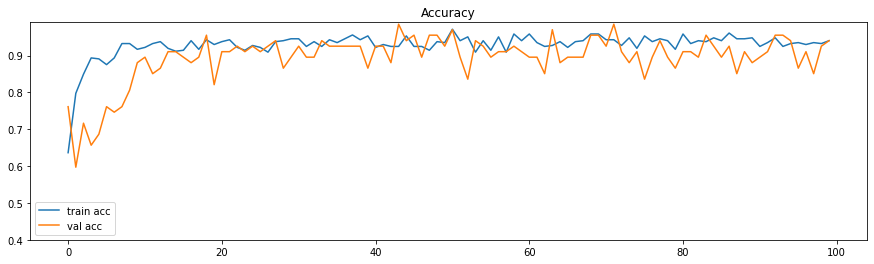

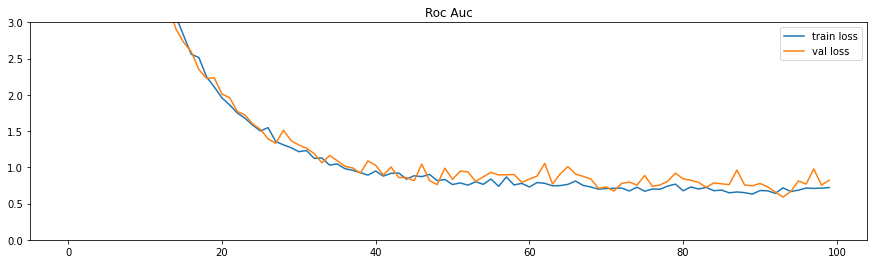

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(history.history["acc"],label="train acc")
plt.plot(history.history["val_acc"], label="val acc")
plt.ylim(0.4,0.99)
plt.title('Accuracy')
plt.legend()
plt.show()
plt.figure(figsize=(15,4))
plt.plot(history.history["loss"],label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.ylim(0,3)
plt.title('Roc Auc')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(rescale(X_test))
print('AUC score:', round(roc_auc_score(y_test, y_pred), 3))
print('Accuracy:', round(accuracy_score(y_test, np.where(y_pred>0.2, 1, 0)), 3))

AUC score: 0.692
Accuracy: 0.665


***Save model***

In [ ]:
model.save(f'{models_dir}model_v{model_version}', overwrite=True)

In [30]:
!cd ${models_dir} && zip -r model_v${model_version}.zip model_v${model_version}

  adding: model_v3/ (stored 0%)
  adding: model_v3/variables/ (stored 0%)
  adding: model_v3/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: model_v3/variables/variables.index (deflated 77%)
  adding: model_v3/assets/ (stored 0%)
  adding: model_v3/saved_model.pb (deflated 92%)
  adding: model_v3/keras_metadata.pb (deflated 96%)
